
# Store Performance Analysis (Single CSV Version)
**입력:** 미리 병합된 단일 CSV (열 예시: ENCODED_MCT, TA_YM, MCT_OPE_MS_CN, RC_M1_SAA, RC_M1_TO_UE_CT, RC_M1_UE_CUS_CN, RC_M1_AV_NP_AT, APV_CE_RAT, DLV_SAA_RAT, M1_SME_RY_SAA_RAT, M1_SME_RY_CNT_RAT, M12_SME_RY_SAA_PCE_RT, M12_SME_BZN_SAA_PCE_RT, ... , ARE_D, MCT_ME_D)

본 노트북은 **하나의 통합 CSV**만으로 다음을 수행합니다.
1) 인코딩 친화적 로드 및 컬럼 **별칭(aliase) 자동 매핑**
2) 전처리 / 특성 엔지니어링 (서열형 라벨 → 정수 등)
3) **업장 유형 분류**(규칙 기반 5종)
4) **KMeans 군집화(k=5)**
5) **성과 스코어링 & High/Mid/Low 라벨**
6) 결과 **CSV/Excel** 내보내기 + 기본 차트

> 원본 3개 CSV가 없어도 동작합니다. 열 이름의 `*_RT`/`*_RAT`와 같은 표기 차이도 자동 처리합니다.


## 0) Configure path

In [1]:

from pathlib import Path

# ⛳️ 여기를 당신의 통합 CSV 경로로 바꾸세요.
# 예: Path('/mnt/data/combined_store_month_utf8_clean.csv')
COMBINED_CSV = Path('./combined_store_data_utf8_sig.csv')


## 1) Imports & helpers

In [2]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def smart_read_csv(path: Path):
    for enc in ['utf-8', 'utf-8-sig', 'cp949', 'euc-kr']:
        try:
            return pd.read_csv(path, dtype=str, encoding=enc)
        except Exception:
            continue
    # 최종 폴백
    return pd.read_csv(path, dtype=str)

def normalize_ta_ym(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace(r'[^0-9]', '', regex=True).str.strip()
    return s.str.zfill(6).str[-6:]

def to_month(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace(r'[^0-9]', '', regex=True).str.zfill(6).str[-6:]
    return pd.to_datetime(s + '01', format='%Y%m%d', errors='coerce')

def leading_int_from_label(v):
    """'5_75-90%' → 5 (int) 같은 서열형 라벨 파싱."""
    try:
        if isinstance(v, str) and '_' in v:
            return int(v.split('_',1)[0])
        return np.nan
    except Exception:
        return np.nan

def first_present(df, candidates):
    """주어진 후보 컬럼명 목록 중, 실제 df에 존재(또는 부분일치)하는 첫 컬럼 반환."""
    if df is None or len(df.columns)==0:
        return None
    norm = {c: ''.join(ch for ch in c.lower() if ch.isalnum()) for c in df.columns}
    for cand in candidates:
        tnorm = ''.join(ch for ch in cand.lower() if ch.isalnum())
        # exact
        for c, n in norm.items():
            if n == tnorm:
                return c
        # contains
        for c, n in norm.items():
            if tnorm in n:
                return c
    return None


## 2) Load single combined CSV

In [3]:

df = smart_read_csv(COMBINED_CSV)
print('Loaded shape:', df.shape)
df.head(3)


Loaded shape: (86590, 38)


,ENCODED_MCT,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,DLV_SAA_RAT,M1_SME_RY_SAA_RAT,...,RC_M1_SHC_WP_UE_CLN_RAT,RC_M1_SHC_FLP_UE_CLN_RAT,MCT_BSE_AR,MCT_NM,MCT_BRD_NUM,MCT_SIGUNGU_NM,HPSN_MCT_ZCD_NM,HPSN_MCT_BZN_CD_NM,ARE_D,MCT_ME_D
0,000F03E44A,202404,4_50-75%,5_75-90%,5_75-90%,5_75-90%,5_75-90%,1_상위1구간,-999999.9,2.6,...,12.5,75,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,20220225,NaN
1,000F03E44A,202312,4_50-75%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,-999999.9,0,...,-999999.9,-999999.9,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,20220225,NaN
2,002816BA73,202404,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,96.6,...,23.8,52.4,서울 성동구 청계천로10나길 78,자갈***********,NaN,서울 성동구,요리주점,마장동,20140507,NaN


## 3) Column aliasing (map various spellings to canonical names)

In [ ]:

# Canonical names we will use throughout
ALIASES = {
    'ENCODED_MCT': ['ENCODED_MCT','가맹점구분번호'],
    'TA_YM': ['TA_YM','기준년월','년월','YYYYMM'],
    'MCT_NM': ['MCT_NM','가맹점명'], ## 우리******
    'MCT_SIGUNGU_NM': ['MCT_SIGUNGU_NM'], #가맹점 지역
    'MCT_BRD_NUM': ['MCT_BRD_NUM','브랜드','브랜드코드'],
    'MCT_BSE_AR': ['MCT_BSE_AR','주소','가맹점주소'],
    'HPSN_MCT_ZCD_NM': ['HPSN_MCT_ZCD_NM','업종'],
    'HPSN_MCT_BZN_CD_NM': ['HPSN_MCT_BZN_CD_NM','상권'],
    'ARE_D': ['ARE_D','개설일','오픈일'],
    'MCT_ME_D': ['MCT_ME_D','폐업일'],

    # Performance / composition
    'MCT_OPE_MS_CN': ['MCT_OPE_MS_CN'],
    'RC_M1_SAA': ['RC_M1_SAA'],                      # 매출금액 구간(라벨)
    'RC_M1_TO_UE_CT': ['RC_M1_TO_UE_CT'],            # 건수 구간(라벨)
    'RC_M1_UE_CUS_CN': ['RC_M1_UE_CUS_CN'],          # 유니크 고객수 구간(라벨)
    'RC_M1_AV_NP_AT': ['RC_M1_AV_NP_AT'],            # 객단가 구간(라벨)
    'APV_CE_RAT': ['APV_CE_RAT','APV_CE_RT'],        # 취소율 구간(라벨)
    'DLV_SAA_RAT': ['DLV_SAA_RAT','DLV_SAA_RT'],     # 배달매출 비중(%)

    'M1_SME_RY_SAA_RAT': ['M1_SME_RY_SAA_RAT','M1_SME_RY_SAA_RT'], # 업종대비 매출 금액 평균 대비 해당 가맹점 금액 비율(=100 평균)
    'M1_SME_RY_CNT_RAT': ['M1_SME_RY_CNT_RAT','M1_SME_RY_CT_RAT','M1_SME_RY_CNT_RT','M1_SME_RY_CT_RT'], ## 동일 업종 매출 건수 평균 대비

    'M12_SME_RY_SAA_PCE_RT': ['M12_SME_RY_SAA_PCE_RT','M12_SME_RY_SAA_PCE_RAT','M12_SME_RY_SAA_PCE_PCT'], #업종 내 매출 순위
    'M12_SME_BZN_SAA_PCE_RT': ['M12_SME_BZN_SAA_PCE_RT','M12_SME_BZN_SAA_PCE_RAT','M12_SME_BZN_SAA_PCE_PCT'], #동일 상권 내 매출 순위

    'M12_SME_RY_ME_MCT_RAT': ['M12_SME_RY_ME_MCT_RAT','M12_SME_RY_ME_MCT_RT'], #동일 업종 내 해지 가맹점 비중
    'M12_SME_BZN_ME_MCT_RAT': ['M12_SME_BZN_ME_MCT_RAT','M12_SME_BZN_ME_MCT_RT'], # 동일 상권 내 해지 가맹점 비중

    # Gender/age & customer mix
    'M12_MAL_1020_RAT': ['M12_MAL_1020_RAT','M12_MAL_1020_RT'], #1020대 남성 고객 비중
    'M12_MAL_30_RAT': ['M12_MAL_30_RAT','M12_MAL_30_RT'], #30대 남성
    'M12_MAL_40_RAT': ['M12_MAL_40_RAT','M12_MAL_40_RT'],
    'M12_MAL_50_RAT': ['M12_MAL_50_RAT','M12_MAL_50_RT'],
    'M12_MAL_60_RAT': ['M12_MAL_60_RAT','M12_MAL_60_RT'],
    'M12_FME_1020_RAT': ['M12_FME_1020_RAT','M12_FME_1020_RT'],
    'M12_FME_30_RAT': ['M12_FME_30_RAT','M12_FME_30_RT'],
    'M12_FME_40_RAT': ['M12_FME_40_RAT','M12_FME_40_RT'],
    'M12_FME_50_RAT': ['M12_FME_50_RAT','M12_FME_50_RT'],
    'M12_FME_60_RAT': ['M12_FME_60_RAT','M12_FME_60_RT'],

    'MCT_UE_CLN_REU_RAT': ['MCT_UE_CLN_REU_RAT','MCT_UE_CLN_REU_RT'], # 재방문 비중(%)
    'MCT_UE_CLN_NEW_RAT': ['MCT_UE_CLN_NEW_RAT','MCT_UE_CLN_NEW_RT'], # 신규 비중(%)

    'RC_M1_SHC_RSD_UE_CLN_RAT': ['RC_M1_SHC_RSD_UE_CLN_RAT','RC_M1_SHC_RSD_UE_CLN_RT'], #거주 이용 고객 비율
    'RC_M1_SHC_WP_UE_CLN_RAT':  ['RC_M1_SHC_WP_UE_CLN_RAT','RC_M1_SHC_WP_UE_CLN_RT'], #직장 이용 고객 비율 
    'RC_M1_SHC_FLP_UE_CLN_RAT': ['RC_M1_SHC_FLP_UE_CLN_RAT','RC_M1_SHC_FLP_UE_CLN_RT'], # 유동인구 고객 비율
}

# Build a rename map automatically
rename_map = {}
for canon, cands in ALIASES.items():
    found = first_present(df, cands)
    if found:
        rename_map[found] = canon

df = df.rename(columns=rename_map)

missing_essentials = [c for c in ['ENCODED_MCT','TA_YM'] if c not in df.columns]
assert len(missing_essentials)==0, f"필수 키 컬럼 누락: {missing_essentials}"

# Standardize keys & month
df['ENCODED_MCT'] = df['ENCODED_MCT'].astype(str).str.strip()
df['TA_YM'] = normalize_ta_ym(df['TA_YM'])
df['YM'] = to_month(df['TA_YM'])

print('Columns mapped:', len(rename_map), '->', list(rename_map.values())[:10], '...')
df.head(2)$$


Columns mapped: 38 -> ['ENCODED_MCT', 'TA_YM', 'MCT_NM', 'MCT_SIGUNGU_NM', 'MCT_BRD_NUM', 'MCT_BSE_AR', 'HPSN_MCT_ZCD_NM', 'HPSN_MCT_BZN_CD_NM', 'ARE_D', 'MCT_ME_D'] ...


,ENCODED_MCT,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,DLV_SAA_RAT,M1_SME_RY_SAA_RAT,...,RC_M1_SHC_FLP_UE_CLN_RAT,MCT_BSE_AR,MCT_NM,MCT_BRD_NUM,MCT_SIGUNGU_NM,HPSN_MCT_ZCD_NM,HPSN_MCT_BZN_CD_NM,ARE_D,MCT_ME_D,YM
0,000F03E44A,202404,4_50-75%,5_75-90%,5_75-90%,5_75-90%,5_75-90%,1_상위1구간,-999999.9,2.6,...,75,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,20220225,NaN,2024-04-01
1,000F03E44A,202312,4_50-75%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,-999999.9,0,...,-999999.9,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,20220225,NaN,2023-12-01


## 4) Cleaning & type conversion

In [5]:

# Convert special missing
df = df.replace({'-999999.9': np.nan, '-999999': np.nan})

# Date columns
def to_date8(s):
    if s is None: return pd.NaT
    s = s.astype(str).str.replace(r'[^0-9]','', regex=True).str.zfill(8).str[-8:]
    return pd.to_datetime(s, format='%Y%m%d', errors='coerce')

df['OPEN_D'] = to_date8(df.get('ARE_D')) if 'ARE_D' in df.columns else pd.NaT
df['CLOSE_D'] = to_date8(df.get('MCT_ME_D')) if 'MCT_ME_D' in df.columns else pd.NaT

# Numeric columns to coerce
num_candidates = [
    'M1_SME_RY_SAA_RAT','M1_SME_RY_CNT_RAT',
    'M12_SME_RY_SAA_PCE_RT','M12_SME_BZN_SAA_PCE_RT',
    'M12_SME_RY_ME_MCT_RAT','M12_SME_BZN_ME_MCT_RAT',
    'DLV_SAA_RAT','MCT_UE_CLN_REU_RAT','MCT_UE_CLN_NEW_RAT',
    'RC_M1_SHC_RSD_UE_CLN_RAT','RC_M1_SHC_WP_UE_CLN_RAT','RC_M1_SHC_FLP_UE_CLN_RAT',
    'M12_MAL_1020_RAT','M12_MAL_30_RAT','M12_MAL_40_RAT','M12_MAL_50_RAT','M12_MAL_60_RAT',
    'M12_FME_1020_RAT','M12_FME_30_RAT','M12_FME_40_RAT','M12_FME_50_RAT','M12_FME_60_RAT'
]
for c in num_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Filter to existing months if open/close available
mask = df['YM'].notna()
if 'OPEN_D' in df:
    mask &= df['OPEN_D'].isna() | (df['YM'] >= df['OPEN_D'].dt.to_period('M').dt.to_timestamp())
if 'CLOSE_D' in df:
    mask &= df['CLOSE_D'].isna() | (df['YM'] <= df['CLOSE_D'].dt.to_period('M').dt.to_timestamp())
df = df.loc[mask].copy()

# Deduplicate
df = df.sort_values(['ENCODED_MCT','YM']).drop_duplicates(['ENCODED_MCT','YM'], keep='last').reset_index(drop=True)
print('Cleaned shape:', df.shape)


Cleaned shape: (86590, 41)


## 5) Feature engineering (ordinals, YoY)

In [6]:
def add_yoy_means_per_store(
    df: pd.DataFrame,
    snap: pd.DataFrame,
    metrics=('M1_SME_RY_SAA_RAT','M1_SME_RY_CNT_RAT'),
    window_months=None,   # None이면 "가능한 모든 월"의 YoY 평균, 정수면 최근 K개월 평균
    min_points=1          # YoY 평균을 계산하기 위한 최소 유효 개수
):
    df2 = df.sort_values(['ENCODED_MCT','YM']).copy()

    # 숫자 변환
    for m in metrics:
        if m in df2.columns:
            df2[m] = pd.to_numeric(df2[m], errors='coerce')

    # 최근 K개월 범위 마스크(옵션)
    if window_months is not None:
        # 각 점포의 마지막 YM 기준으로 최근 K개월 범위 선정
        last_ym = df2.groupby('ENCODED_MCT')['YM'].transform('max')
        # 마지막 달 포함 K개월: 예) 12면 last_ym - 11개월 이상
        cutoff = last_ym - pd.DateOffset(months=window_months - 1)
        in_window = df2['YM'] >= cutoff
    else:
        in_window = pd.Series(True, index=df2.index)

    for m in metrics:
        if m not in df2.columns:
            continue

        # ❶ 월별 YoY 계산 (각 점포별 12개월 차분) → 월 단위 시계열에 붙임
        col_yoy = f'{m}_YOY'
        df2[col_yoy] = df2.groupby('ENCODED_MCT', group_keys=False)[m].diff(12)

        # ❷ YoY가 존재하는 월들만 모아 가맹점별 집계(평균/표준편차/개수)
        mask = in_window & df2[col_yoy].notna()
        agg = (df2.loc[mask]
                 .groupby('ENCODED_MCT')[col_yoy]
                 .agg(yoy_mean='mean', yoy_std='std', yoy_n='count')
                 .reset_index())

        # ❸ 컬럼명: amount_idx/count_idx 체계로 매핑
        alias = 'amount_idx' if m == 'M1_SME_RY_SAA_RAT' else 'count_idx'
        agg = agg.rename(columns={
            'yoy_mean': f'{alias}_YOY_MEAN',
            'yoy_std':  f'{alias}_YOY_STD',
            'yoy_n':    f'{alias}_YOY_N'
        })


        # ❹ 최소 샘플 개수 미만이면 평균은 NaN 처리(신뢰도 통제)
        agg.loc[agg[f'{alias}_YOY_N'] < min_points, f'{alias}_YOY_MEAN'] = np.nan

        # ❺ 스냅샷에 병합
        snap = snap.merge(agg, on='ENCODED_MCT', how='left')

    return df2, snap
# Ordinal parse for label columns
for lbl in ['MCT_OPE_MS_CN','RC_M1_SAA','RC_M1_TO_UE_CT','RC_M1_UE_CUS_CN','RC_M1_AV_NP_AT','APV_CE_RAT']:
    if lbl in df.columns:
        df[f'{lbl}_LV'] = df[lbl].apply(leading_int_from_label)

# YoY for amount/count  ✅ apply → transform/diff 로 교체
for metric in ['M1_SME_RY_SAA_RAT','M1_SME_RY_CNT_RAT']:
    if metric in df.columns:
        # 숫자형 변환(안전)
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        # 방법 A: transform + shift
        df[f'{metric}_YOY'] = df.groupby('ENCODED_MCT')[metric].transform(lambda s: s - s.shift(12))
        # 방법 B(동일 효과, 더 간단): diff(12)
        # df[f'{metric}_YOY'] = df.groupby('ENCODED_MCT')[metric]

# Snapshot (latest month per store)  ✅ all-NaT 방지 & 정렬 보장
idx_last = (
    df.sort_values(['ENCODED_MCT','YM'])
      .groupby('ENCODED_MCT', as_index=False, sort=False)
      .tail(1)
      .index
)
snap = df.loc[idx_last].copy().reset_index(drop=True)

# Canonical column names for downstream
rename_for_model = {
    'M1_SME_RY_SAA_RAT': 'amount_idx', #업종내 매출 순위
    'M1_SME_RY_CNT_RAT': 'count_idx', # 업종내 건수 순위
    'M12_SME_RY_SAA_PCE_RT': 'rank_industry_pct',
    'M12_SME_BZN_SAA_PCE_RT': 'rank_tradearea_pct',
    'DLV_SAA_RAT': 'delivery_pct',
    'MCT_UE_CLN_NEW_RAT': 'new_pct',
    'MCT_UE_CLN_REU_RAT': 'repeat_pct',
    'RC_M1_SHC_RSD_UE_CLN_RAT': 'residential_pct',
    'RC_M1_SHC_WP_UE_CLN_RAT': 'workplace_pct',
    'RC_M1_SHC_FLP_UE_CLN_RAT': 'floating_pct',
    'RC_M1_AV_NP_AT_LV': 'ticket_level',
    'RC_M1_TO_UE_CT_LV': 'freq_level'
}
snap = snap.rename(columns={k:v for k,v in rename_for_model.items() if k in snap.columns})

# Ensure numeric
for c in ['amount_idx','count_idx','rank_industry_pct','rank_tradearea_pct','delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct','ticket_level','freq_level']:
    if c in snap.columns:
        snap[c] = pd.to_numeric(snap[c], errors='coerce')

# Cap ratios to [0,100]
for c in ['delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct']:
    if c in snap.columns:
        snap.loc[snap[c] < 0, c] = np.nan
        snap.loc[snap[c] > 100, c] = np.nan

# Append YoY to snapshot if available
for metric in ['M1_SME_RY_SAA_RAT','M1_SME_RY_CNT_RAT']:
    col = f'{metric}_YOY'
    if col in df.columns:
        snap[col.replace(metric,'amount_idx' if 'SAA' in metric else 'count_idx')] = df.loc[idx_last, col].values

df, snap = add_yoy_means_per_store(df, snap, window_months=None, min_points=1)

# Keep some ID/meta
for keep in ['ENCODED_MCT','MCT_NM','MCT_SIGUNGU_NM','MCT_BRD_NUM','MCT_BSE_AR','HPSN_MCT_ZCD_NM','HPSN_MCT_BZN_CD_NM','YM']:
    if keep not in snap.columns and keep in df.columns:
        snap[keep] = df.loc[idx_last, keep].values

snap.head(3)


,ENCODED_MCT,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,delivery_pct,amount_idx,...,M1_SME_RY_SAA_RAT_YOY,M1_SME_RY_CNT_RAT_YOY,amount_idx_YOY,count_idx_YOY,amount_idx_YOY_MEAN,amount_idx_YOY_STD,amount_idx_YOY_N,count_idx_YOY_MEAN,count_idx_YOY_STD,count_idx_YOY_N
0,000F03E44A,202412,4_50-75%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,5_75-90%,1_상위1구간,78.0,0.7,...,0.7,4.1,0.7,4.1,3.000000,4.430268,12.0,3.925000,3.657651,12.0
1,002816BA73,202412,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,NaN,113.5,...,-75.8,-12.0,-75.8,-12.0,-10.208333,37.401494,12.0,-4.966667,10.275773,12.0
2,003473B465,202412,3_25-50%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,-2.125000,4.038705,12.0,-1.091667,1.863261,12.0


## 6) Rule-based 5-type classification

In [7]:

def classify_store_type(row):
    # 1) 배달 전문형: 배달 비중 높음
    if pd.notna(row.get('delivery_pct')) and row['delivery_pct'] >= 50:
        return '배달 전문형'
    # 2) 전문 특화형: 고객단가↑·빈도↓ 또는 amount>>count
    ticket = row.get('ticket_level')
    freq   = row.get('freq_level')
    amt    = row.get('amount_idx')
    cnt    = row.get('count_idx')
    ratio  = None
    if pd.notna(amt) and pd.notna(cnt) and cnt>0:
        ratio = amt / max(cnt, 1e-6)
    if (pd.notna(ticket) and pd.notna(freq) and ticket >= 5 and (pd.isna(freq) or freq <= 3)) or (ratio is not None and ratio >= 1.6):
        return '전문 특화형'
    # 3) 주거/오피스/상업: 우세 활동권
    res, wp, flp = row.get('residential_pct'), row.get('workplace_pct'), row.get('floating_pct')
    vals = {'주거': res, '오피스': wp, '상업': flp}
    dom = None if all(pd.isna(list(vals.values()))) else max(vals, key=lambda k: -1e9 if pd.isna(vals[k]) else vals[k])
    if dom == '상업' and (pd.isna(flp) or flp >= 50):  return '상업 중심지형'
    if dom == '오피스' and (pd.isna(wp)  or wp  >= 40): return '오피스 밀집지역형'
    if dom == '주거' and (pd.isna(res) or res >= 40):  return '주거지역 밀착형'
    # Fallback
    return '주거지역 밀착형'

snap['store_type_rule'] = snap.apply(classify_store_type, axis=1)
snap['store_type_rule'].value_counts()


store_type_rule
전문 특화형       1374
주거지역 밀착형     1278
상업 중심지형      1029
배달 전문형        388
오피스 밀집지역형     116
Name: count, dtype: int64

## 7) KMeans clustering (k=5)

In [8]:

features = ['delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct','amount_idx','count_idx','ticket_level','freq_level']
X = snap[features].copy()

imp = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_imp = imp.fit_transform(X)
X_std = scaler.fit_transform(X_imp)

k=5
km = KMeans(n_clusters=k, n_init=20, random_state=42)
snap['cluster_k5'] = km.fit_predict(X_std)

try:
    sil = silhouette_score(X_std, snap['cluster_k5'])
    print('Silhouette:', round(sil,3))
except Exception as e:
    print('Silhouette not available:', e)

# Centroids (inverse transform)
centers = scaler.inverse_transform(km.cluster_centers_)
centroids_df = pd.DataFrame(centers, columns=features)
centroids_df.index.name = 'cluster'
centroids_df


Silhouette: 0.217


,delivery_pct,new_pct,repeat_pct,residential_pct,workplace_pct,floating_pct,amount_idx,count_idx,ticket_level,freq_level
cluster,,,,,,,,,,
0,17.022566,8.531667,31.440118,19.394985,36.142478,44.462684,98.379499,139.874484,3.743363,3.072271
1,16.364706,8.713214,26.860462,30.635714,11.667857,57.674790,445.824160,542.421218,3.726891,1.502101
2,19.983573,7.924955,34.076661,62.014542,6.732944,30.921993,87.806104,108.333662,3.597846,3.449731
3,17.190265,13.199579,15.889525,18.420483,7.037150,74.480919,129.664408,84.945405,2.341121,3.761682
4,49.065245,5.009731,20.497188,37.880253,7.892259,48.713270,15.769352,19.940126,4.925750,5.161137


## 8) Performance scoring & success labeling

In [ ]:

def invert_rank(x):
    return np.nan if pd.isna(x) else (100 - x)

if 'rank_industry_pct' in snap.columns:
    snap['inv_rank_industry'] = snap['rank_industry_pct'].apply(invert_rank)
if 'rank_tradearea_pct' in snap.columns:
    snap['inv_rank_tradearea'] = snap['rank_tradearea_pct'].apply(invert_rank)

def group_z(s, g):
    mu = s.groupby(g).transform('mean')
    sd = s.groupby(g).transform('std').replace(0, np.nan)
    return (s - mu) / sd

for c in ['amount_idx','count_idx','inv_rank_industry','inv_rank_tradearea']:
    if c in snap.columns:
        snap[f'z_{c}'] = group_z(pd.to_numeric(snap[c], errors='coerce'), snap['store_type_rule'])

# Add YoY if present
if 'count_idx_YOY_MEAN' in snap.columns:
    snap['count_idx_YOY_MEAN'] = pd.to_numeric(snap['count_idx_YOY_MEAN'], errors='coerce')

snap['perf_score'] = (
    0.40 * snap.get('z_amount_idx', 0) +
    0.30 * snap.get('z_count_idx', 0) +
    0.20 * snap.get('z_inv_rank_industry', 0) +
    0.10 * snap.get('count_idx_YOY_MEAN', 0).fillna(0)
)$

labels = []
for t, sdf in snap.groupby('store_type_rule'):
    q75 = sdf['perf_score'].quantile(0.75)
    q25 = sdf['perf_score'].quantile(0.25)
    lab = np.where(sdf['perf_score']>=q75, 'High',
          np.where(sdf['perf_score']<=q25, 'Low', 'Mid'))
    labels.append(pd.Series(lab, index=sdf.index))
snap['success_label'] = pd.concat(labels).sort_index()

mn, mx = snap['perf_score'].min(), snap['perf_score'].max()
snap['perf_score_global'] = ((snap['perf_score'] - mn)/(mx - mn) * 100).clip(0, 100)

snap[['ENCODED_MCT','MCT_NM','MCT_SIGUNGU_NM','store_type_rule','cluster_k5','perf_score_global','success_label']].head(10)


,ENCODED_MCT,MCT_NM,MCT_SIGUNGU_NM,store_type_rule,cluster_k5,perf_score_global,success_label
0,000F03E44A,육육**,서울 성동구,배달 전문형,4,60.455035,Mid
1,002816BA73,자갈***********,서울 성동구,전문 특화형,3,60.278175,Mid
2,003473B465,바틀****************,서울 성동구,주거지역 밀착형,4,60.147787,Mid
3,003AC99735,메가************,서울 성동구,전문 특화형,1,63.747991,High
4,0041E4E5AE,엄마****,서울 성동구,상업 중심지형,1,60.813449,Mid
5,0050D68B18,70**************,서울 성동구,전문 특화형,3,61.672435,High
6,00646B6673,봉밀******,서울 성동구,배달 전문형,2,61.765441,High
7,0074C4990A,대용**,서울 성동구,전문 특화형,3,60.773789,Mid
8,007BE37BA2,토리******,서울 성동구,상업 중심지형,3,59.862494,Mid
9,00803E9174,포도****,서울 성동구,전문 특화형,3,60.431655,Mid


## 9) (Optional) Margin proxy

profit_proxy_rel = (amount_idx / 100) × margin_assumed
amount_idx / 100
= 해당 점포 매출 / 동종 평균 매출
(예: amount_idx=120 → 동종 평균 대비 매출이 1.2배)

margin_assumed
= 해당 점포의 추정 영업이익률 (0~1)
(지역·업종·상권유형 베이스 + 배달/결제/포장 페널티로 조정한 값)

곱(product)
= 동종 평균 매출을 1로 놓았을 때 이 점포의 예상 영업이익(상대값).
단위가 돈이 아니라 무차원(relative) 값이죠.

https://merchants.doordash.com/en-us/blog/food-cost-percentage?utm_source=chatgpt.com


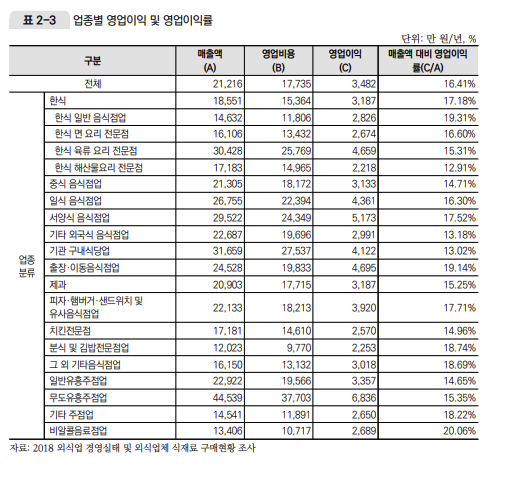
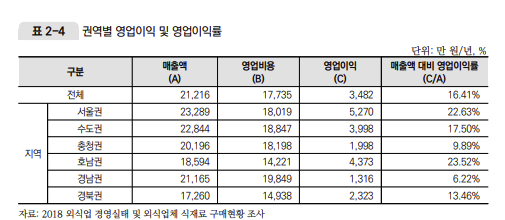
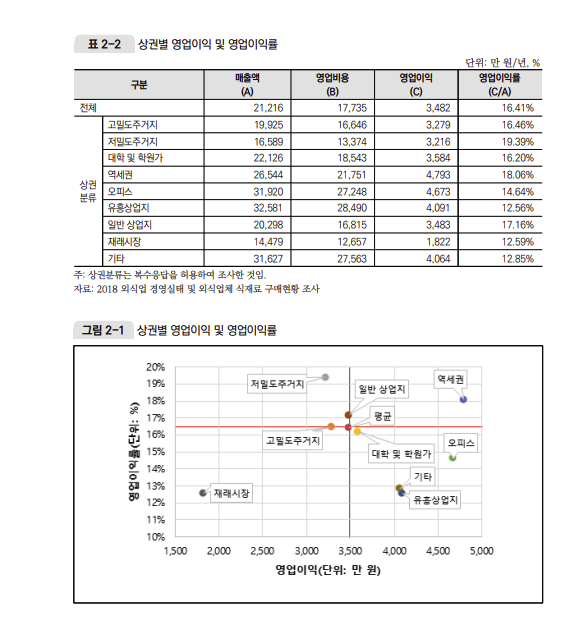

In [ ]:

if 'delivery_pct' in snap.columns:
    snap['delivery_pct'] = pd.to_numeric(snap['delivery_pct'], errors='coerce')
if 'amount_idx' in snap.columns:
    snap['amount_idx'] = pd.to_numeric(snap['amount_idx'], errors='coerce')
if 'ticket_level' in snap.columns:
    snap['ticket_level'] = pd.to_numeric(snap['ticket_level'], errors='coerce')

MARGIN_ASSUMPTION = {
    '주거지역 밀착형': 0.150,
    '오피스 밀집지역형': 0.155,
    '상업 중심지형':   0.175,
    '배달 전문형':     0.135,
    '전문 특화형':     0.125,
}
PLATFORM_FEE_DELIVERY = 0.12
PAYMENT_FEE          = 0.012
PACKAGING_KRW        = 800
AOV_BY_LEVEL = {1:8000, 2:10000, 3:13000, 4:18000, 5:24000, 6:35000}
DEFAULT_AOV = 15000

def estimate_oper_margin(row):
    base = MARGIN_ASSUMPTION.get(row.get('store_type_rule'), 0.15)

    # ✅ NaN 안전 처리 (NaN → 0.0), % → 0~1
    val = pd.to_numeric(row.get('delivery_pct'), errors='coerce')
    d = 0.0 if pd.isna(val) else float(val) / 100.0

    # ✅ ticket_level 없으면 기본 AOV 사용
    tlev = pd.to_numeric(row.get('ticket_level'), errors='coerce')
    aov  = AOV_BY_LEVEL.get(int(tlev), DEFAULT_AOV) if pd.notna(tlev) else DEFAULT_AOV

    pkg_pct = (PACKAGING_KRW / max(aov, 1)) if d > 0 else 0.0
    penalty = (d * (PLATFORM_FEE_DELIVERY + pkg_pct)) + PAYMENT_FEE

    est = base - penalty
    return float(np.clip(est, 0.0, 0.30))  # 음수 방지, 상한 캡

snap['margin_assumed'] = snap.apply(estimate_oper_margin, axis=1)

# profit proxy (amount_idx가 NaN이면 결과도 NaN)
if 'amount_idx' in snap.columns:
    snap['profit_proxy_rel'] = (snap['amount_idx'] / 100.0) * snap['margin_assumed']
else:
    snap['profit_proxy_rel'] = np.nan

snap[['ENCODED_MCT','MCT_NM','store_type_rule','amount_idx','margin_assumed','profit_proxy_rel']].head(10)



,ENCODED_MCT,MCT_NM,store_type_rule,amount_idx,margin_assumed,profit_proxy_rel
0,000F03E44A,육육**,배달 전문형,0.7,0.003400,0.000024
1,002816BA73,자갈***********,전문 특화형,113.5,0.113000,0.128255
2,003473B465,바틀****************,주거지역 밀착형,0.0,0.138000,0.000000
3,003AC99735,메가************,전문 특화형,254.3,0.110000,0.279730
4,0041E4E5AE,엄마****,상업 중심지형,218.4,0.140307,0.306430
5,0050D68B18,70**************,전문 특화형,478.5,0.113000,0.540705
6,00646B6673,봉밀******,배달 전문형,78.7,0.003366,0.002649
7,0074C4990A,대용**,전문 특화형,134.7,0.113000,0.152211
8,007BE37BA2,토리******,상업 중심지형,192.8,0.163000,0.314264
9,00803E9174,포도****,전문 특화형,104.1,0.113000,0.117633


## 10) Export results

In [11]:

from pathlib import Path
OUT_CSV  = Path('./store_scores_single.csv')
OUT_XLSX = Path('./store_report_single.xlsx')

export_cols = [
    'ENCODED_MCT','MCT_NM','MCT_SIGUNGU_NM','MCT_BRD_NUM','MCT_BSE_AR','HPSN_MCT_ZCD_NM','HPSN_MCT_BZN_CD_NM','YM',
    'store_type_rule','cluster_k5',
    'amount_idx','count_idx','rank_industry_pct','rank_tradearea_pct',
    'delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct',
    'ticket_level','freq_level',
    'count_idx_YOY_MEAN','perf_score','success_label','profit_proxy_rel'
]
out_df = snap.reindex(columns=[c for c in export_cols if c in snap.columns])
out_df.to_csv(OUT_CSV, index=False, encoding='utf-8-sig')
print('Saved:', OUT_CSV)

with pd.ExcelWriter(OUT_XLSX, engine='openpyxl') as writer:
    out_df.to_excel(writer, sheet_name='Stores', index=False)
    type_summary = out_df.pivot_table(index='store_type_rule', columns='success_label', values='ENCODED_MCT', aggfunc='count', fill_value=0)
    type_summary.to_excel(writer, sheet_name='TypeSummary')
    try:
        centroids_df.to_excel(writer, sheet_name='ClusterCentroids')
    except Exception:
        pass

print('Saved:', OUT_XLSX)


Saved: store_scores_single.csv
Saved: store_report_single.xlsx


## 11) Quick charts

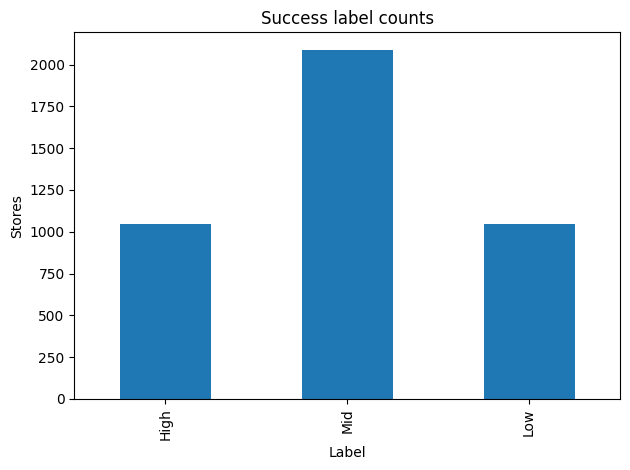

In [17]:

# Success label distribution
plt.figure()
snap['success_label'].value_counts().reindex(['High','Mid','Low']).fillna(0).plot(kind='bar', title='Success label counts')
plt.xlabel('Label'); plt.ylabel('Stores'); plt.tight_layout(); plt.show()


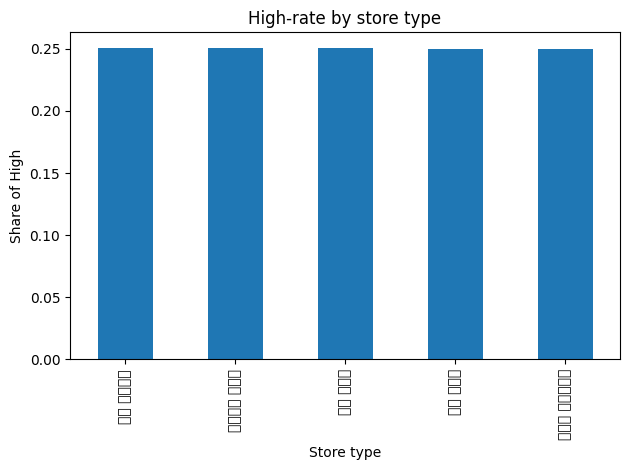

In [18]:

# High share by store type
plt.figure()
(snap.groupby('store_type_rule')['success_label'].apply(lambda s: (s=='High').mean()).sort_values(ascending=False)).plot(kind='bar', title='High-rate by store type')
plt.xlabel('Store type'); plt.ylabel('Share of High'); plt.tight_layout(); plt.show()


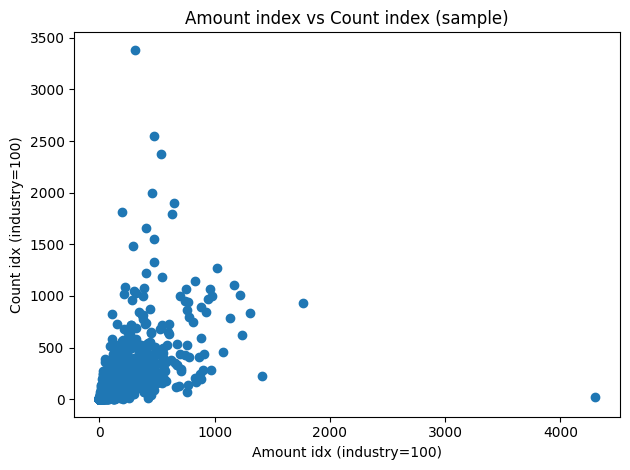

In [19]:

# Amount vs Count scatter (sample)
sample = snap[['amount_idx','count_idx']].dropna().sample(min(2000, len(snap)), random_state=42) if len(snap)>0 else snap
plt.figure()
plt.scatter(sample['amount_idx'], sample['count_idx'])
plt.title('Amount index vs Count index (sample)')
plt.xlabel('Amount idx (industry=100)'); plt.ylabel('Count idx (industry=100)'); plt.tight_layout(); plt.show()


In [12]:
df = snap.copy()
cols = list(df.columns)

# Helper: coerce to numeric safely
def to_num(s):
    try:
        return pd.to_numeric(s, errors='coerce')
    except Exception:
        return pd.Series([np.nan]*len(s))

# Pretty value formatting by semantic
def fmt_value(col, val):
    if pd.isna(val) or val == '':
        return 'null'
    # Try numeric formatting cases
    try:
        vnum = float(val)
    except Exception:
        vnum = None

    pct_cols = {'delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct'}
    if col in pct_cols and vnum is not None:
        return f"{vnum:.1f}%"
    if col in {'rank_industry_pct','rank_tradearea_pct'} and vnum is not None:
        return f"{vnum:.1f}% (낮을수록 상위)"
    if col in {'perf_score'} and vnum is not None:
        return f"{vnum:.1f} / 100"
    if col in {'oper_margin_est','oper_margin_base','margin_assumed'} and vnum is not None:
        return f"{vnum*100:.1f}%"
    if col in {'oper_profit_proxy_rel','profit_proxy_rel'} and vnum is not None:
        return f"{vnum:.4f} (상대 영업이익 지표)"
    if col in {'amount_idx','count_idx','amount_idx_YOY','count_idx_YOY','amount_idx_YOY_MEAN','count_idx_YOY_MEAN'} and vnum is not None:
        return f"{vnum:.1f} (업종 평균=100)"
    if col in {'cluster_k5'} and vnum is not None:
        return f"군집 {int(vnum)}"
    if col in {'ticket_level','freq_level'} and vnum is not None:
        return f"레벨 {int(vnum)} (1~6)"
    # YM
    if col == 'YM':
        sval = str(val)
        if len(sval) >= 7 and '-' in sval:
            return sval[:7]
        if len(sval) == 6 and sval.isdigit():
            return f"{sval[:4]}-{sval[4:]}"
        return sval
    return str(val)

# Human-friendly labels & meanings (only used if column exists)
LABELS = {
    'ENCODED_MCT': ('가맹점 코드','고유 식별자'),
    'MCT_NM': ('가맹점명','상호명'),
    'MCT_BSE_AR': ('주소','도로명 주소'),
    'MCT_SIGUNGU_NM': ('행정구','시·군·구'),
    'MCT_BRD_NUM': ('브랜드코드','프랜차이즈/브랜드 구분'),
    'HPSN_MCT_ZCD_NM': ('업종','카테고리(예: 한식, 치킨 등)'),
    'HPSN_MCT_BZN_CD_NM': ('상권명','상권/생활권 명칭'),
    'YM': ('기준월','데이터 기준 연월(YYYY-MM)'),
    'store_type_rule': ('유형(규칙)','주거/오피스/상업/배달/특화 분류'),
    'cluster_k5': ('군집(k=5)','데이터 기반 클러스터 번호'),
    'amount_idx': ('매출지수','동일 업종 평균=100 대비 매출'),
    'count_idx': ('건수지수','동일 업종 평균=100 대비 이용건수'),
    'rank_industry_pct': ('업종내 순위%','낮을수록 상위'),
    'rank_tradearea_pct': ('상권내 순위%','낮을수록 상위'),
    'delivery_pct': ('배달 매출 비중','%'),
    'new_pct': ('신규 고객 비중','%'),
    'repeat_pct': ('재방문 고객 비중','%'),
    'residential_pct': ('거주 이용 비중','%'),
    'workplace_pct': ('직장 이용 비중','%'),
    'floating_pct': ('유동 이용 비중','%'),
    'ticket_level': ('객단가 레벨','1~6 (높을수록 고가)'),
    'freq_level': ('방문빈도 레벨','1~6 (높을수록 다빈도)'),
    'amount_idx_YOY': ('매출지수 YoY','전년동월 대비 변화(지수)'),
    'count_idx_YOY': ('건수지수 YoY','전년동월 대비 변화(지수)'),
    'amount_idx_YOY_MEAN': ('매출지수 YoY 평균','최근 기간 평균'),
    'count_idx_YOY_MEAN': ('건수지수 YoY 평균','최근 기간 평균'),
    'perf_score': ('성과점수','유형 내 0~100 정규화'),
    'success_label': ('라벨','High/Mid/Low'),
    'region_group': ('권역','서울/수도권/충청/호남/경남/강원/기타'),
    'sector_group': ('업종(정규화)','키워드 기반 대분류'),
    'oper_margin_base': ('베이스 영업이익률','지역×업종×유형 가중 평균'),
    'oper_margin_est': ('추정 영업이익률','배달/결제/포장 조정 후'),
    'oper_profit_proxy_rel': ('상대 영업이익 지표','(매출지수×이익률)'),
    'margin_assumed': ('추정 이익률','(구 버전)'),
    'profit_proxy_rel': ('상대 영업이익 지표','(매출지수×이익률, 구 버전)'),
}

# Define a canonical ordering for columns we care to show first
ORDER = [
    'ENCODED_MCT','MCT_NM','MCT_BSE_AR','MCT_SIGUNGU_NM','HPSN_MCT_ZCD_NM','HPSN_MCT_BZN_CD_NM','YM',
    'store_type_rule','cluster_k5',
    'amount_idx','count_idx','rank_industry_pct','rank_tradearea_pct',
    'delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct',
    'ticket_level','freq_level',
    'amount_idx_YOY','count_idx_YOY','amount_idx_YOY_MEAN','count_idx_YOY_MEAN',
    'perf_score','success_label',
    'region_group','sector_group','oper_margin_base','oper_margin_est','oper_profit_proxy_rel',
    'margin_assumed','profit_proxy_rel'
]

# Keep only those that exist in df
ordered_cols = [c for c in ORDER if c in df.columns]
# Any remaining columns not in ORDER will be appended at the end
other_cols = [c for c in df.columns if c not in ordered_cols]

def build_prompt(row: pd.Series) -> str:
    # Instruction header kept neutral so you can re-use the string as a prompt anywhere
    parts = ["[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 값을 그대로 해석해 주세요."]
    # Iterate in order
    for c in ordered_cols + other_cols:
        val = row.get(c, np.nan)
        label, desc = LABELS.get(c, (c, ''))
        parts.append(f"- {label}" + (f"({desc})" if desc else "") + f" = {fmt_value(c, val)}")
    # A short footer describing conventions
    parts.append("※ 규칙: 매출/건수 지수는 업종 평균=100, 순위%는 낮을수록 상위, 이익률은 % 기준.")
    return "\n".join(parts)

df['prompt_str'] = df.apply(build_prompt, axis=1)

# Save
out_path = Path('./store_scores_with_prompt.csv')
df.to_csv(out_path, index=False, encoding='utf-8-sig')

In [13]:
path_with_prompt = Path('./store_scores_with_prompt.csv')
path_single = Path('./store_scores_single.csv')

if path_with_prompt.exists():
    df = pd.read_csv(path_with_prompt, dtype=str, encoding='utf-8')
else:
    df = pd.read_csv(path_single, dtype=str, encoding='utf-8')

# Ensure cluster is numeric
if 'cluster_k5' in df.columns:
    df['cluster_k5'] = pd.to_numeric(df['cluster_k5'], errors='coerce')
else:
    # If there's no cluster, we can't proceed with labeling
    raise RuntimeError("cluster_k5 column not found.")

# Coerce helpful numeric columns
for c in ['delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct',
          'amount_idx','count_idx','ticket_level','freq_level','rank_industry_pct','rank_tradearea_pct']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Build cluster profiles
features = [c for c in ['delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct',
          'amount_idx','count_idx','ticket_level','freq_level','rank_industry_pct','rank_tradearea_pct'] if c in df.columns]

profiles = []
for k, g in df.groupby('cluster_k5'):
    med = g[features].median(numeric_only=True)
    ratio = None
    if 'amount_idx' in med and 'count_idx' in med and not pd.isna(med['count_idx']) and med['count_idx'] > 0:
        ratio = med['amount_idx'] / med['count_idx']
    # Heuristic labeling
    label = '혼합형'
    if 'delivery_pct' in med and med['delivery_pct'] >= 40:
        label = '배달 중심'
    if 'ticket_level' in med and 'freq_level' in med:
        if (not pd.isna(med['ticket_level']) and med['ticket_level'] >= 5) and \
           (pd.isna(med['freq_level']) or med['freq_level'] <= 3):
            label = '고가·저빈도 특화'
    if ratio is not None and ratio >= 1.6:
        label = '고가·저빈도 특화'
    if 'floating_pct' in med and 'new_pct' in med:
        if med['floating_pct'] >= 50 and med['new_pct'] >= 30:
            label = '유동·신규 중심'
    if 'workplace_pct' in med and med['workplace_pct'] >= 45:
        label = '오피스·런치 중심'
    if 'residential_pct' in med and 'repeat_pct' in med:
        if med['residential_pct'] >= 50 and med['repeat_pct'] >= 30:
            label = '주거·단골 중심'
    # Majority rule-type
    if 'store_type_rule' in g.columns:
        top_type = g['store_type_rule'].mode().iloc[0] if not g['store_type_rule'].mode().empty else ''
        share = (g['store_type_rule'] == top_type).mean() if top_type != '' else np.nan
    else:
        top_type, share = '', np.nan
    # Build a short summary string
    def pct(v):
        return None if pd.isna(v) else f"{float(v):.0f}%"
    def lvl(v):
        return None if pd.isna(v) else f"{int(v)}"
    summ_bits = []
    if 'delivery_pct' in med: summ_bits.append(f"배달 {pct(med['delivery_pct'])}")
    if 'floating_pct' in med: summ_bits.append(f"유동 {pct(med['floating_pct'])}")
    if 'residential_pct' in med: summ_bits.append(f"거주 {pct(med['residential_pct'])}")
    if 'workplace_pct' in med: summ_bits.append(f"직장 {pct(med['workplace_pct'])}")
    if 'new_pct' in med: summ_bits.append(f"신규 {pct(med['new_pct'])}")
    if 'repeat_pct' in med: summ_bits.append(f"재방문 {pct(med['repeat_pct'])}")
    if 'ticket_level' in med: summ_bits.append(f"객단가레벨 {lvl(med['ticket_level'])}")
    if 'freq_level' in med: summ_bits.append(f"빈도레벨 {lvl(med['freq_level'])}")
    if 'amount_idx' in med: summ_bits.append(f"매출지수 {float(med['amount_idx']):.0f}")
    if 'count_idx' in med: summ_bits.append(f"건수지수 {float(med['count_idx']):.0f}")
    if ratio is not None: summ_bits.append(f"고가/저빈도지수 {ratio:.2f}")
    if top_type:
        summ_bits.append(f"대표유형 {top_type}({share*100:.0f}%)")
    summary = ", ".join([s for s in summ_bits if s is not None])

    profiles.append({
        'cluster_k5': k,
        'cluster_label': label,
        'cluster_summary': summary
    })

prof_df = pd.DataFrame(profiles)

# Merge back to rows
df = df.merge(prof_df, on='cluster_k5', how='left')

# Update prompt_str if exists: inject cluster_label & summary near the top
if 'prompt_str' in df.columns:
    def inject_prompt(row):
        header = f"- 군집(k=5) = {int(row['cluster_k5']) if pd.notna(row['cluster_k5']) else 'null'} / 군집명(의미) = {row.get('cluster_label','')}"
        summary = f"- 군집 요약 = {row.get('cluster_summary','')}"
        # Put header+summary at the second line for visibility
        p = str(row['prompt_str'])
        lines = p.splitlines()
        if len(lines) >= 1:
            return "\n".join([lines[0], header, summary] + lines[1:])
        else:
            return "\n".join([header, summary, p])
    df['prompt_str'] = df.apply(inject_prompt, axis=1)

out_path = Path('./store_scores_with_clusterlabel.csv')
df.to_csv(out_path, index=False, encoding='utf-8-sig')

In [16]:
src = Path('./store_scores_with_clusterlabel.csv')
df = pd.read_csv(src, dtype=str, encoding='utf-8')

# Coerce numerics needed
num_cols = ['cluster_k5','delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct',
            'amount_idx','count_idx','ticket_level','freq_level']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Recompute cluster medians to be explicit and keep as separate columns
features = ['delivery_pct','new_pct','repeat_pct','residential_pct','workplace_pct','floating_pct',
            'amount_idx','count_idx','ticket_level','freq_level']

med_map = df.groupby('cluster_k5')[features].median(numeric_only=True)

def pct(v): return None if pd.isna(v) else f"{float(v):.0f}%"
def lvl(v): return None if pd.isna(v) else f"{int(v)}"

def build_cluster_median_summary(k):
    if k not in med_map.index:
        return ""
    m = med_map.loc[k]
    bits = []
    if 'delivery_pct' in m:   bits.append(f"배달 {pct(m['delivery_pct'])}")
    if 'floating_pct' in m:   bits.append(f"유동 {pct(m['floating_pct'])}")
    if 'residential_pct' in m:bits.append(f"거주 {pct(m['residential_pct'])}")
    if 'workplace_pct' in m:  bits.append(f"직장 {pct(m['workplace_pct'])}")
    if 'new_pct' in m:        bits.append(f"신규 {pct(m['new_pct'])}")
    if 'repeat_pct' in m:     bits.append(f"재방문 {pct(m['repeat_pct'])}")
    if 'ticket_level' in m:   bits.append(f"객단가레벨 {lvl(m['ticket_level'])}")
    if 'freq_level' in m:     bits.append(f"빈도레벨 {lvl(m['freq_level'])}")
    if 'amount_idx' in m:     bits.append(f"매출지수 {float(m['amount_idx']):.0f}")
    if 'count_idx' in m:      bits.append(f"건수지수 {float(m['count_idx']):.0f}")
    return ", ".join([b for b in bits if b])

def build_my_summary(r):
    bits = []
    def getv(col):
        return r[col] if col in r.index else np.nan
    if 'delivery_pct' in r.index:   bits.append(f"배달 {pct(getv('delivery_pct'))}")
    if 'floating_pct' in r.index:   bits.append(f"유동 {pct(getv('floating_pct'))}")
    if 'residential_pct' in r.index:bits.append(f"거주 {pct(getv('residential_pct'))}")
    if 'workplace_pct' in r.index:  bits.append(f"직장 {pct(getv('workplace_pct'))}")
    if 'new_pct' in r.index:        bits.append(f"신규 {pct(getv('new_pct'))}")
    if 'repeat_pct' in r.index:     bits.append(f"재방문 {pct(getv('repeat_pct'))}")
    if 'ticket_level' in r.index:   bits.append(f"객단가레벨 {lvl(getv('ticket_level'))}")
    if 'freq_level' in r.index:     bits.append(f"빈도레벨 {lvl(getv('freq_level'))}")
    if 'amount_idx' in r.index and not pd.isna(getv('amount_idx')): bits.append(f"매출지수 {float(getv('amount_idx')):.1f}")
    if 'count_idx' in r.index and not pd.isna(getv('count_idx')):   bits.append(f"건수지수 {float(getv('count_idx')):.1f}")
    return ", ".join([b for b in bits if b])

# New columns
df['cluster_summary_med'] = df['cluster_k5'].map(build_cluster_median_summary)
df['my_summary'] = df.apply(build_my_summary, axis=1)

# Update prompt_str
if 'prompt_str' in df.columns:
    def inject(row):
        ck = row.get('cluster_k5')
        clabel = row.get('cluster_label','')
        head = f"- 군집(k=5) = {int(ck) if pd.notna(ck) else 'null'} / 군집명(의미) = {clabel}"
        medline = f"- 군집 요약(중앙값) = {row.get('cluster_summary_med','')}"
        myline  = f"- 내 매장 요약 = {row.get('my_summary','')}"
        lines = str(row['prompt_str']).splitlines()
        if len(lines) >= 1:
            return "\n".join([lines[0], head, medline, myline] + lines[3:])  # replace earlier 2 lines
        else:
            return "\n".join([head, medline, myline])
    df['prompt_str'] = df.apply(inject, axis=1)

out = Path('./store_scores_with_clusterlabel_v2.csv')
df.to_csv(out, index=False, encoding='utf-8-sig')
df

,ENCODED_MCT,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,delivery_pct,amount_idx,...,perf_score,success_label,perf_score_global,margin_assumed,profit_proxy_rel,prompt_str,cluster_label,cluster_summary,cluster_summary_med,my_summary
0,000F03E44A,202412,4_50-75%,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,5_75-90%,1_상위1구간,78.0,0.7,...,-0.3499528487081358,Mid,60.45503508569615,0.003400000000000014,2.3800000000000097e-05,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,배달 중심,"배달 85%, 유동 47%, 거주 44%, 직장 5%, 신규 2%, 재방문 20%,...","배달 85%, 유동 47%, 거주 44%, 직장 5%, 신규 2%, 재방문 20%,...","배달 78%, 유동 75%, 거주 0%, 직장 25%, 신규 7%, 재방문 11%,..."
1,002816BA73,202412,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,NaN,113.5,...,-0.7099225319855105,Mid,60.27817509696285,0.113,0.128255,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,고가·저빈도 특화,"배달 7%, 유동 75%, 거주 17%, 직장 6%, 신규 8%, 재방문 14%, ...","배달 7%, 유동 75%, 거주 17%, 직장 6%, 신규 8%, 재방문 14%, ...","배달 None, 유동 84%, 거주 12%, 직장 3%, 신규 9%, 재방문 11%..."
2,003473B465,202412,3_25-50%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,NaN,0.0,...,-0.9753057365344738,Mid,60.147787253911154,0.13799999999999998,0.0,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,배달 중심,"배달 85%, 유동 47%, 거주 44%, 직장 5%, 신규 2%, 재방문 20%,...","배달 85%, 유동 47%, 거주 44%, 직장 5%, 신규 2%, 재방문 20%,...","배달 None, 유동 None, 거주 None, 직장 None, 신규 None, 재..."
3,003AC99735,202412,3_25-50%,3_25-50%,1_10%이하,1_10%이하,6_90%초과(하위 10% 이하),2_상위2구간,2.1,254.3,...,6.352322169856298,High,63.747990963198255,0.11,0.27973000000000003,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,혼합형,"배달 9%, 유동 57%, 거주 30%, 직장 9%, 신규 7%, 재방문 26%, ...","배달 9%, 유동 57%, 거주 30%, 직장 9%, 신규 7%, 재방문 26%, ...","배달 2%, 유동 53%, 거주 37%, 직장 10%, 신규 5%, 재방문 37%,..."
4,0041E4E5AE,202412,3_25-50%,2_10-25%,2_10-25%,2_10-25%,4_50-75%,1_상위1구간,13.8,218.4,...,0.37954010125707727,Mid,60.813448921375915,0.14030666666666664,0.30642975999999994,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,혼합형,"배달 9%, 유동 57%, 거주 30%, 직장 9%, 신규 7%, 재방문 26%, ...","배달 9%, 유동 57%, 거주 30%, 직장 9%, 신규 7%, 재방문 26%, ...","배달 14%, 유동 62%, 거주 28%, 직장 10%, 신규 8%, 재방문 31%..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180,FFAC8CC0F7,202412,1_10%이하,6_90%초과(하위 10% 이하),5_75-90%,5_75-90%,3_25-50%,1_상위1구간,0.0,0.9,...,-26.510685530544592,Low,47.60176687366353,0.13799999999999998,0.001242,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,고가·저빈도 특화,"배달 7%, 유동 75%, 거주 17%, 직장 6%, 신규 8%, 재방문 14%, ...","배달 7%, 유동 75%, 거주 17%, 직장 6%, 신규 8%, 재방문 14%, ...","배달 0%, 유동 None, 거주 None, 직장 None, 신규 0%, 재방문 2..."
4181,FFD5654C3D,202412,2_10-25%,3_25-50%,3_25-50%,3_25-50%,3_25-50%,1_상위1구간,1.3,119.6,...,-2.4191037325124634,Low,59.43842169018653,0.13563999999999998,0.16222543999999997,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,주거·단골 중심,"배달 18%, 유동 32%, 거주 62%, 직장 5%, 신규 6%, 재방문 32%,...","배달 18%, 유동 32%, 거주 62%, 직장 5%, 신규 6%, 재방문 32%,...","배달 1%, 유동 46%, 거주 40%, 직장 14%, 신규 6%, 재방문 18%,..."
4182,FFE9F1CC6A,202412,6_90%초과(하위 10% 이하),2_10-25%,3_25-50%,3_25-50%,2_10-25%,6_상위6구간(하위1구간),NaN,239.9,...,-0.1701716958013064,Mid,60.54336500389391,0.113,0.271087,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,고가·저빈도 특화,"배달 7%, 유동 75%, 거주 17%, 직장 6%, 신규 8%, 재방문 14%, ...","배달 7%, 유동 75%, 거주 17%, 직장 6%, 신규 8%, 재방문 14%, ...","배달 None, 유동 40%, 거주 48%, 직장 13%, 신규 100%, 재방문 ..."
4183,FFEDAC5747,202412,3_25-50%,1_10%이하,1_10%이하,1_10%이하,4_50-75%,3_상위3구간,11.5,239.9,...,0.047325619207438496,Mid,60.65022559374066,0.11908888888888888,0.2856942444444444,[DATA: 가맹점 단일 스냅샷] 각 항목은 '필드명(설명)=값' 형식입니다. 이 ...,주거·단골 중심,"배달 18%, 유동 32%, 거주 62%, 직장 5%, 신규 6%, 재방문 32%,...","배달 18%, 유동 32%, 거주 62%, 직장 5%, 신규 6%, 재방문 32%,...","배달 12%, 유동 24%, 거주 68%, 직장 8%, 신규 6%, 재방문 41%,..."


In [24]:
# Load the latest file with cluster info
candidates = [
    Path('./store_scores_with_clusterlabel_v2.csv'),
    Path('./store_scores_with_clusterlabel.csv'),
    Path('./store_scores_with_prompt.csv'),
    Path('./store_scores_single.csv')
]
for p in candidates:
    if p.exists():
        src = p
        break
else:
    raise FileNotFoundError("No input CSV found.")

df = pd.read_csv(src, dtype=str, encoding='utf-8')

# -----------------------------
# 1) 기본 설정
# -----------------------------
# 성과 지표 선택(존재하는 첫 컬럼 사용)
PERF_CAND = ["perf_score_global", "perf_score", "oper_profit_proxy_rel", "profit_proxy_rel", "amount_idx"]
perf_col = next((c for c in PERF_CAND if c in df.columns), None)
if perf_col is None:
    raise KeyError("성과 지표 컬럼이 없습니다. (perf_score_global / perf_score / oper_profit_proxy_rel / profit_proxy_rel / amount_idx 중 1개 필요)")

# 후보 피처(증감 타깃 산정용) — 순위%는 제외 (낮을수록 상위 지표이므로 혼동 방지)
FEAT_COLS = [
    "delivery_pct","new_pct","repeat_pct","residential_pct","workplace_pct","floating_pct",
    "ticket_level","freq_level","amount_idx","count_idx"
]
FEAT_COLS = [c for c in FEAT_COLS if c in df.columns]

# 사람이 읽기 쉬운 라벨
NAME_MAP = {
    "delivery_pct"   : "배달 매출 비중",
    "new_pct"        : "신규 고객 비중",
    "repeat_pct"     : "재방문 고객 비중",
    "residential_pct": "거주 이용 비중",
    "workplace_pct"  : "직장 이용 비중",
    "floating_pct"   : "유동 이용 비중",
    "ticket_level"   : "객단가 레벨",
    "freq_level"     : "방문빈도 레벨",
    "amount_idx"     : "매출 지수(업종=100)",
    "count_idx"      : "건수 지수(업종=100)",
}

# 포맷터
def fmt_value(col: str, v) -> str:
    if pd.isna(v):
        return "null"
    if col in {"delivery_pct","new_pct","repeat_pct","residential_pct","workplace_pct","floating_pct"}:
        return f"{float(v):.1f}%"
    if col in {"ticket_level","freq_level"}:
        return f"{int(float(v))}"
    # 지수/숫자
    return f"{float(v):.1f}"

# -----------------------------
# 2) 전처리(숫자형 강제)
# -----------------------------
num_cols = set(FEAT_COLS + [perf_col] + (["cluster_k5"] if "cluster_k5" in df.columns else []))
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# my_summary, cluster_summary_med 없을 경우 간이 생성
def build_my_summary(r: pd.Series) -> str:
    bits = []
    for f in ["delivery_pct","floating_pct","residential_pct","workplace_pct","new_pct","repeat_pct"]:
        if f in r and not pd.isna(r[f]):
            bits.append(f"{NAME_MAP.get(f,f).replace(' 비중','')} {fmt_value(f, r[f])}")
    for f in ["ticket_level","freq_level","amount_idx","count_idx"]:
        if f in r and not pd.isna(r[f]):
            nm = NAME_MAP.get(f,f)
            bits.append(f"{nm.split()[0]} {fmt_value(f, r[f])}")
    return ", ".join(bits)

def build_cluster_median_summary(k, med_df) -> str:
    if k not in med_df.index:
        return ""
    m = med_df.loc[k]
    bits = []
    for f in ["delivery_pct","floating_pct","residential_pct","workplace_pct","new_pct","repeat_pct"]:
        if f in m and not pd.isna(m[f]):
            bits.append(f"{NAME_MAP.get(f,f).replace(' 매출','').replace(' 비중','')} {fmt_value(f, m[f])}")
    for f in ["ticket_level","freq_level","amount_idx","count_idx"]:
        if f in m and not pd.isna(m[f]):
            nm = NAME_MAP.get(f,f)
            bits.append(f"{nm.split()[0]} {fmt_value(f, m[f])}")
    return ", ".join(bits)

# -----------------------------
# 3) 군집 중앙값 / 상관 (Spearman)
# -----------------------------
# 군집이 없으면 전체를 한 군집처럼 처리
if "cluster_k5" not in df.columns:
    df["cluster_k5"] = 0

# 군집별 중앙값
med_df = df.groupby("cluster_k5")[FEAT_COLS].median(numeric_only=True)

# 군집별 스피어만 상관(피처 vs 성과)
def spearman(g: pd.DataFrame, x: str, y: str) -> float:
    # pandas 내장 스피어만 상관
    try:
        if g[[x, y]].dropna().shape[0] < 5:
            return np.nan
        return g[[x, y]].corr(method="spearman").iloc[0,1]
    except Exception:
        return np.nan

corr_map = {}
for k, g in df.groupby("cluster_k5"):
    corrs = {}
    for f in FEAT_COLS:
        corrs[f] = spearman(g, f, perf_col)
    corr_map[k] = corrs

# 전체(글로벌) 폴백
global_corr = {}
for f in FEAT_COLS:
    global_corr[f] = spearman(df, f, perf_col)

def get_corr(k, f):
    v = corr_map.get(k, {}).get(f, np.nan)
    if pd.isna(v):
        v = global_corr.get(f, np.nan)
    return v

# -----------------------------
# 4) 올릴/낮출 지표 선정
# -----------------------------
def build_targets_up(r: pd.Series, topn: int = 3) -> str:
    k = r["cluster_k5"]
    if k not in med_df.index:
        return "올릴 지표 없음"
    med = med_df.loc[k]

    recs = []
    for f in FEAT_COLS:
        my, md, corr = r.get(f), med.get(f, np.nan), get_corr(k, f)
        my = float(my) if not pd.isna(my) else np.nan
        if not (pd.notna(my) and pd.notna(md) and pd.notna(corr)):
            continue
        # 양(+)의 상관 & 내 값이 군집 중앙보다 낮으면 '올리기'
        if corr > 0 and my < md:
            denom = abs(md) if abs(md) > 1e-6 else 1.0
            impact = corr * (md - my) / denom
            recs.append((f, my, md, impact))
    recs.sort(key=lambda x: x[3], reverse=True)
    recs = recs[:topn]
    if not recs:
        return "올릴 지표 없음"
    out = []
    for f, my, md, _ in recs:
        out.append(f"나의 상태 -> 업계 중앙값 ")
        out.append(f"{NAME_MAP.get(f,f)}: {fmt_value(f,my)} -> {fmt_value(f,md)}")
    return "↑ 올릴 지표 Top{}: ".format(len(out)) + "; ".join(out)

def build_targets_down(r: pd.Series, topn: int = 3) -> str:
    k = r["cluster_k5"]
    if k not in med_df.index:
        return "낮출 지표 없음"
    med = med_df.loc[k]

    recs = []
    for f in FEAT_COLS:
        my, md, corr = r.get(f), med.get(f, np.nan), get_corr(k, f)
        my = float(my) if not pd.isna(my) else np.nan
        if not (pd.notna(my) and pd.notna(md) and pd.notna(corr)):
            continue
        # 음(-)의 상관 & 내 값이 군집 중앙보다 높으면 '내리기'
        if corr < 0 and my > md:
            denom = abs(md) if abs(md) > 1e-6 else 1.0
            impact = abs(corr) * (my - md) / denom
            recs.append((f, my, md, impact))
    recs.sort(key=lambda x: x[3], reverse=True)
    recs = recs[:topn]
    if not recs:
        return "낮출 지표 없음"
    out = []
    for f, my, md, _ in recs:
        out.append(f"나의 상태 -> 업계 중앙값 ")
        out.append(f"{NAME_MAP.get(f,f)}: {fmt_value(f,my)} -> {fmt_value(f,md)}")
    return "↓ 낮출 지표 Top{}: ".format(len(out)) + "; ".join(out)

# -----------------------------
# 5) 요약 문자열 보강 + 최종 프롬프트 생성
# -----------------------------
if "my_summary" not in df.columns:
    df["my_summary"] = df.apply(build_my_summary, axis=1)
if "cluster_summary_med" not in df.columns:
    df["cluster_summary_med"] = df["cluster_k5"].apply(lambda k: build_cluster_median_summary(k, med_df))

df["targets_up"] = df.apply(build_targets_up, axis=1)
df["targets_down"] = df.apply(build_targets_down, axis=1)


def build_final_prompt(r: pd.Series) -> str:
    # 식별/머리말
    parts = []
    h1 = f"유형/군집: {r.get('store_type_rule','')} / 군집 {int(r['cluster_k5']) if pd.notna(r.get('cluster_k5')) else 'NA'}({r.get('cluster_label','')})"
    parts.append(h1)
    parts.append(f"내 지표 요약: {r.get('my_summary','')}")
    parts.append(f"업계 중앙값 요약: {r.get('cluster_summary_med','')}")
    parts.append("")  # 빈줄
    # 타깃
    parts.append(str(r.get("targets_up","올릴 지표 없음")))
    parts.append(str(r.get("targets_down","낮출 지표 없음")))
    parts.append("")  # 빈줄
    # 꼬리말
    parts.append(f"종합 평가: {r.get('success_label','')}")
    return "\n".join(parts).strip()

df["analysis_prompt_updown"] = df.apply(build_final_prompt, axis=1)

# -----------------------------
# 6) 저장
# -----------------------------
out = src.with_name(src.stem + "_with_targets_updown.csv")
df.to_csv(out, index=False, encoding="utf-8-sig")